In [1]:
import os
from PIL import Image
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
import networkx as nx

class Config(object):
    # 可调配置
    main_color_size = 10
    clusters = 8
    pic_col_count = 3
    resize = False
    mix_clusters = 6

    
    # 基础配置
    font_offset = 1.5
    standard_size = (224, 224)
    pic_type = 'RGB'
    channel_dim = 3
    seed = 42
    font_style = {
        'color': 'red',
        'size': 10,
        'family': 'Times New Roman'
    }


def load_pic(path):
    pic = Image.open(path)
    pic = pic.convert(Config.pic_type)
    return pic


def make_rgb_color(value):
    assert len(value) == Config.channel_dim
    container = np.zeros(shape=(Config.main_color_size,
                                Config.main_color_size,
                                Config.channel_dim),
                         dtype=np.uint8)
    for i in range(Config.channel_dim):
        container[:, :, i] = value[i]
    res = Image.fromarray(container)
    return container, res


def make_rgb_colors(values):
    pic_num = len(values)
    container = np.zeros(shape=(Config.main_color_size,
                                Config.main_color_size * pic_num,
                                Config.channel_dim),
                         dtype=np.uint8)
    for i in range(pic_num):
        container[:, i * Config.main_color_size: (i + 1) * Config.main_color_size, :] = make_rgb_color(values[i])[0]
    res = Image.fromarray(container)
    return container, res
    

def pic_to_sample(pic):
    arr = np.array(pic)
    return arr.reshape(-1, Config.channel_dim)


def make_model(samples):
    model = KMeans(n_clusters=Config.clusters, random_state=Config.seed)
    model.fit(samples)
    return model


def show_rgh_colors(centers):
    arr = make_rgb_colors(centers)[1]
    plt.figure(figsize=(Config.main_color_size, Config.main_color_size * len(centers)))
    plt.imshow(arr)
    plt.xticks([])
    plt.yticks([])
    for i in range(len(centers)):
        axis_y = Config.main_color_size + Config.font_offset
        axis_x = Config.main_color_size * i + Config.font_offset
        content = '{:3d} {:3d} {:3d}'.format(*centers[i])
        plt.text(axis_x, axis_y, content, fontdict=Config.font_style)
    plt.show()
    
    
def extract_single_pic(path, resize=Config.resize):
    pic = load_pic(path)
    if resize:
        pic = pic.resize(Config.standard_size)
    arr = np.array(pic)
    samples = pic_to_sample(pic)
    model = make_model(samples)
    centers = np.array(model.cluster_centers_, dtype=np.uint8)
    counter = Counter(model.labels_)
    proba = np.array([counter[i] for i in range(model.n_clusters)])
    proba = np.round(proba / np.sum(proba) * 100, 1)
    res = {
        'pic': pic,
        'array': arr,
        'centers': centers,
        'model': model,
        'proba': proba
    }
    return res


def extract_multi_pics(path_list, resize=Config.resize):
    pic_list = [load_pic(path) for path in path_list]
    if resize:
        pic_list = [pic.resize(Config.standard_size) for pic in pic_list]
    arr_list = [np.array(pic) for pic in pic_list]
    samples_list = [pic_to_sample(pic) for pic in pic_list]
    samples = np.concatenate(samples_list, axis=0)
    model = make_model(samples)
    centers = np.array(model.cluster_centers_, dtype=np.uint8)
#     show_rgh_colors(centers)
    res = {
        'pic': pic_list,
        'array': arr_list,
        'centers': centers,
        'model': model
    }
    return res


def show_oral_pics(pics):
    plt.figure(figsize=(Config.main_color_size, Config.main_color_size))
    num = len(pics)
    col = Config.pic_col_count
    row = num // col + int(num % col != 0)
    for i in range(len(pics)):
        plt.subplot(row, col, i + 1)
        plt.axis('off')
        plt.imshow(pics[i])
    plt.show()
    
    
def rgb2hex(rgb):
    r, g, b = rgb
    res = hex((r << 16) + (g << 8) + b)
    res = '#' + res[2:]
    return res


def plot_probability(res):
    proba = res['proba']
    plt.barh(range(len(proba)), proba, color=res['centers'] / 255)
    for i in range(len(proba)):
        plt.text(proba[i] + 0.1, i - 0.1, '{}%  [R: {} G: {} B: {}]'.format(proba[i], *res['centers'][i]))
    plt.axis('off')
    plt.show()
    

def plot_visiual(res):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(res['pic'])
    plt.subplot(1, 2, 2)
    plot_probability(res)
    plt.show()
    
    
def extract_multi_pics_v2(pic_list, resize=Config.resize):
    centers = np.zeros((1, 3))
    weight = np.zeros(1)

    for file in pic_list:
        res = extract_single_pic(file, resize=True)
        centers = np.concatenate([centers, res['centers']], axis=0)
        weight = np.concatenate([weight, res['proba']], axis=0)

    centers = centers[1:, :]
    weight = weight[1:]
    model = KMeans(n_clusters=Config.mix_clusters, random_state=Config.seed)
    model.fit(centers, sample_weight=weight)
    centers = np.array(model.cluster_centers_, dtype=np.uint8)
    counter = Counter(model.labels_)
    proba = np.array([counter[i] for i in range(model.n_clusters)])
    proba = np.round(proba / np.sum(proba) * 100, 1)
    res = {
        'centers': centers,
        'model': model,
        'proba': proba,
    }
    return res


def judge_same(mat, row):
    return ((mat == row).all(axis=1)).any()


In [2]:
files = os.walk('色彩分析图库/')
oral_pics = []
pixel_pics = []
for file in files:
    for f in file[2]:
        if '像素' in f:
            pixel_pics.append(os.path.join(file[0], f))
        else:
            oral_pics.append(os.path.join(file[0], f))
            
files = oral_pics
res_v1 = extract_multi_pics(files, resize=True)
res_v2 = extract_multi_pics_v2(files, resize=True)
colors = [rgb2hex(x) for x in res_v2['centers']]

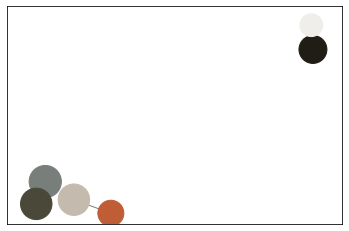

In [4]:
g = nx.Graph()
g.add_edges_from([(0, 1), (2, 3), (4, 5), (5, 3), (5, 2)])

pos = nx.spring_layout(g)

nx.draw_networkx_nodes(g, pos, nodelist=g.nodes(), node_color=colors, node_size=res['proba'] * 50)
nx.draw_networkx_edges(g, pos, edgelist=[(0, 1), (2, 3)], width=3, edge_color='red')
nx.draw_networkx_edges(g, pos, edgelist=[(4, 5)], width=1, alpha=0.5)
# nx.draw_networkx_labels(g, pos, font_size=20, font_family="sans-serif")
plt.show()

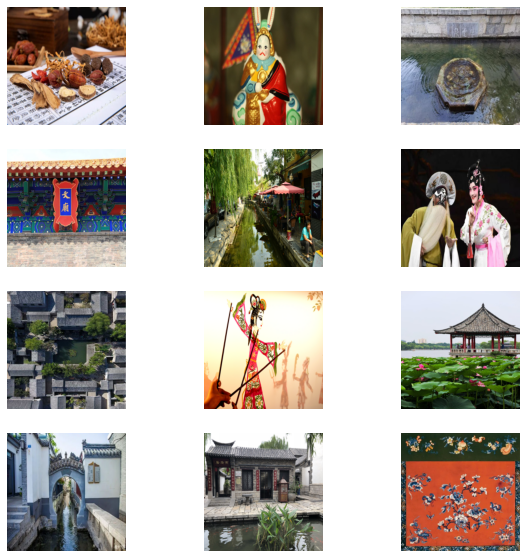

In [8]:
show_oral_pics(res_v1['pic'])

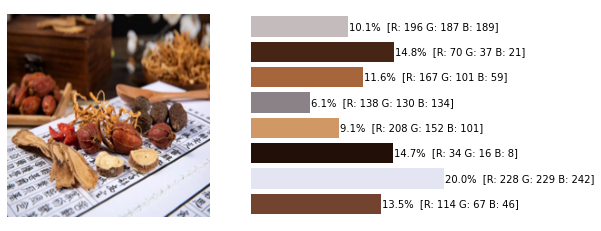

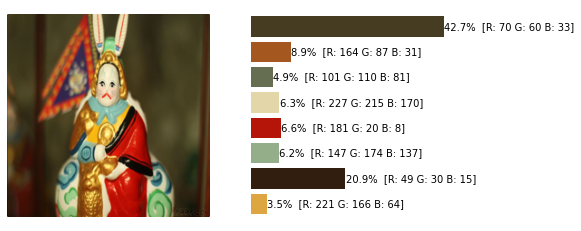

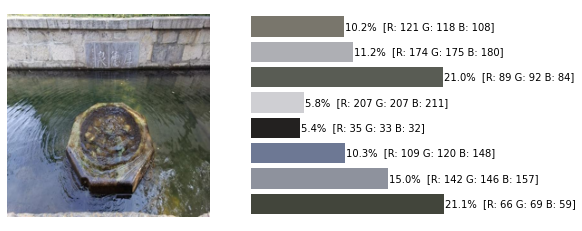

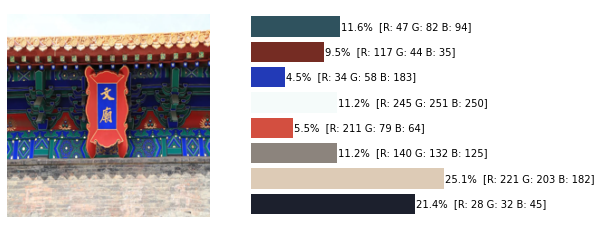

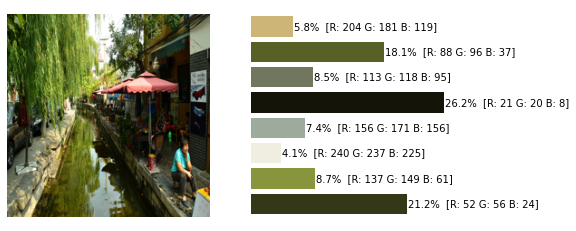

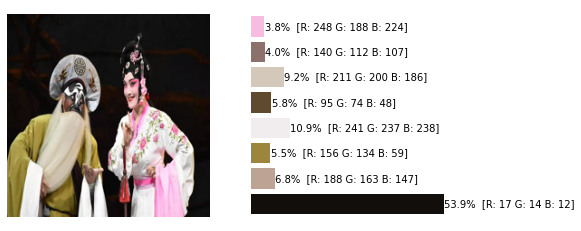

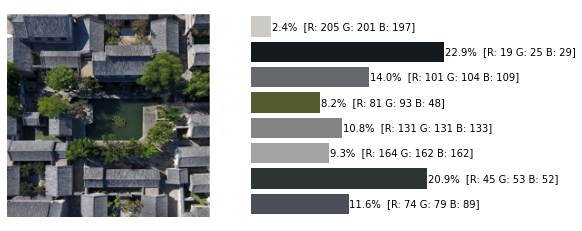

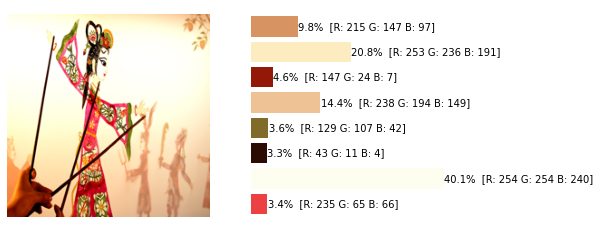

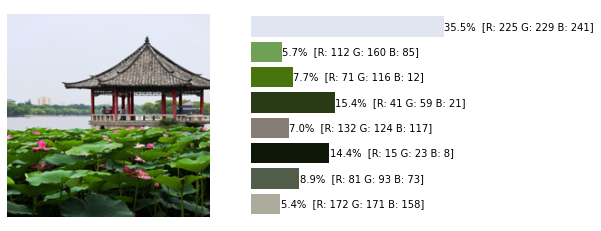

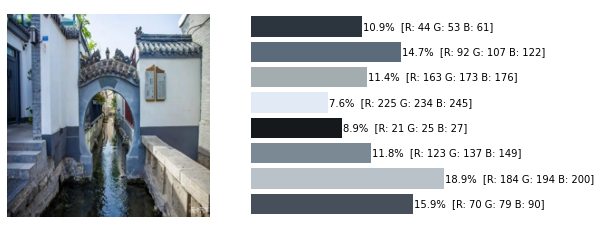

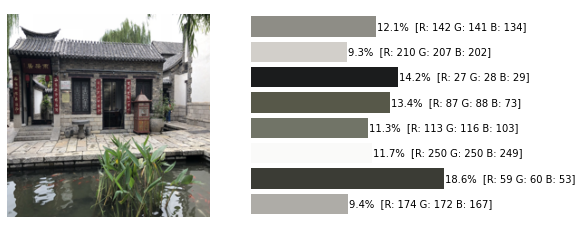

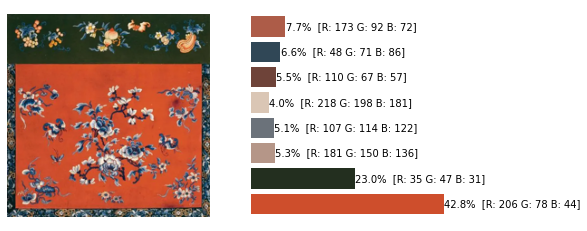

In [9]:


for f in files:
    r = extract_single_pic(f, resize=True)
    plot_visiual(r)

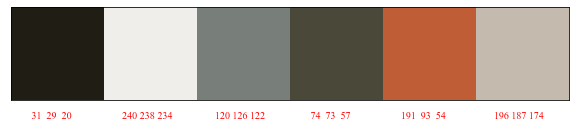

In [7]:
show_rgh_colors(res_v2['centers'])